In [34]:
import warnings
warnings.simplefilter(action='ignore')

In [35]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [421]:
sc.set_figure_params(dpi=100, frameon=False)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### loading the raw data forb both ref and query

In [640]:
adata = sc.read('./covid_raw_sergey.h5ad')

In [641]:
adata.obs.condition2.value_counts()

control (refrence)           154723
severe COVID-19 (query)       36073
control (query)               19137
moderate COVID-19 (query)      7259
Name: condition2, dtype: int64

In [642]:
adata = adata[~adata.obs['study'].isin(['Villani', 'HCL'])].copy()

In [646]:
adata.obs.study.value_counts()

COVID-19 (query)                     62469
Northwestern_Misharin_2018Reyfman    35447
Sanger_Meyer_2019Madissoon           34407
10X                                  10727
Krasnow_distal 3                     10291
Krasnow_distal 2                      6129
Krasnow_distal 1a                     4675
Krasnow_proximal 3                    4248
Krasnow_medial 2                      3981
Oetjen_U                              3730
Freytag                               3347
Oetjen_P                              3265
Oetjen_A                              2586
Sun_sample4_TC                        2420
Sun_sample3_TB                        2403
Sun_sample2_KC                        2281
Sun_sample1_CS                        1725
Name: study, dtype: int64

In [724]:
sca.add_annotations(adata, '../metadata/c2.cp.reactome.v4.0.symbols.gmt', min_genes=12, clean=False)

In [669]:
adata_raw = adata.copy()

Subsetig the query data 

In [670]:
query = adata[adata.obs['study'].isin(['COVID-19 (query)'])].copy()

In [671]:
adata = adata[~adata.obs['study'].isin(['COVID-19 (query)'])].copy()

In [672]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [673]:
adata.layers["counts"] = adata.X.copy()

In [674]:
sc.pp.normalize_total(adata)

In [675]:
sc.pp.log1p(adata)

In [676]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    batch_key="study",
    subset=True)

Selecting terms with >12 genees

In [677]:
select_terms = adata.varm['I'].sum(0)>12

In [678]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [679]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [680]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [681]:
adata.X = adata.layers["counts"].copy()

In [682]:
adata.obs.study.value_counts()

Northwestern_Misharin_2018Reyfman    35447
Sanger_Meyer_2019Madissoon           34407
10X                                  10727
Krasnow_distal 3                     10291
Krasnow_distal 2                      6129
Krasnow_distal 1a                     4675
Krasnow_proximal 3                    4248
Krasnow_medial 2                      3981
Oetjen_U                              3730
Freytag                               3347
Oetjen_P                              3265
Oetjen_A                              2586
Sun_sample4_TC                        2420
Sun_sample3_TB                        2403
Sun_sample2_KC                        2281
Sun_sample1_CS                        1725
Name: study, dtype: int64

In [683]:
adata.obs.condition2

P1_3_TAAGAGAGTGAAGGCT_Krasnow-0-0-1-1-0-2-0    control (refrence)
P2_1_CTACCCAAGATAGCAT_Krasnow-0-0-1-1-0-2-0    control (refrence)
P3_5_AACTGGTCACATGACT_Krasnow-0-0-1-1-0-2-0    control (refrence)
P2_7_GAATGAAGTCGGATCC_Krasnow-0-0-1-1-0-2-0    control (refrence)
P3_4_CATTCGCAGCTAAACA_Krasnow-0-0-1-1-0-2-0    control (refrence)
                                                      ...        
TTTGTCACACCAGATT-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
TTTGTCACACCCAGTG-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
TTTGTCACATCGACGC-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
TTTGTCACATTGAGCT-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
TTTGTCATCCTACAGA-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
Name: condition2, Length: 131662, dtype: category
Categories (1, object): ['control (refrence)']

### Create the model and train it on reference dataset

In [374]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[545, 545],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False,
    use_l_encoder=True,)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 5000 545 16
	Hidden Layer 1 in/out: 545 545
	Mean/Var Layer in/out: 545 545
Encoder Architecture:
	Input Layer in, out and cond: 5000 128 16
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  545 5000 16


In [127]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
ALPHA = 0.7
EPOCHS = 400

In [128]:

intr_cvae.train(
    n_epochs=EPOCHS, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=None,
    alpha_kl=0.25,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020)

 |██████████████████--| 92.8%  - epoch_loss: 1938.01 - epoch_recon_loss: 1885.94 - epoch_kl_loss:  208.26 - val_loss: 2017.89 - val_recon_loss: 1967.06 - val_kl_loss:  203.359
ADJUSTED LR
 |███████████████████-| 98.0%  - epoch_loss: 1941.39 - epoch_recon_loss: 1889.15 - epoch_kl_loss:  208.95 - val_loss: 2015.55 - val_recon_loss: 1964.62 - val_kl_loss:  203.69
ADJUSTED LR
 |████████████████████| 100.0%  - epoch_loss: 1935.74 - epoch_recon_loss: 1883.60 - epoch_kl_loss:  208.56 - val_loss: 2015.42 - val_recon_loss: 1964.53 - val_kl_loss:  203.52
Saving best state of network...
Best State was in Epoch 398


In [723]:

inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


[]

### Visaulizing the reference 

In [130]:
MEAN = False

In [131]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(adata.X.A, adata.obs['study'].tolist(),mean=MEAN)[:, ~inactive_idx]

In [132]:
ref_ss= sc.pp.subsample(adata, copy=True, fraction=0.2)

In [133]:
sc.pp.neighbors(ref_ss, use_rep='X_cvae')

In [134]:
sc.tl.umap(ref_ss)

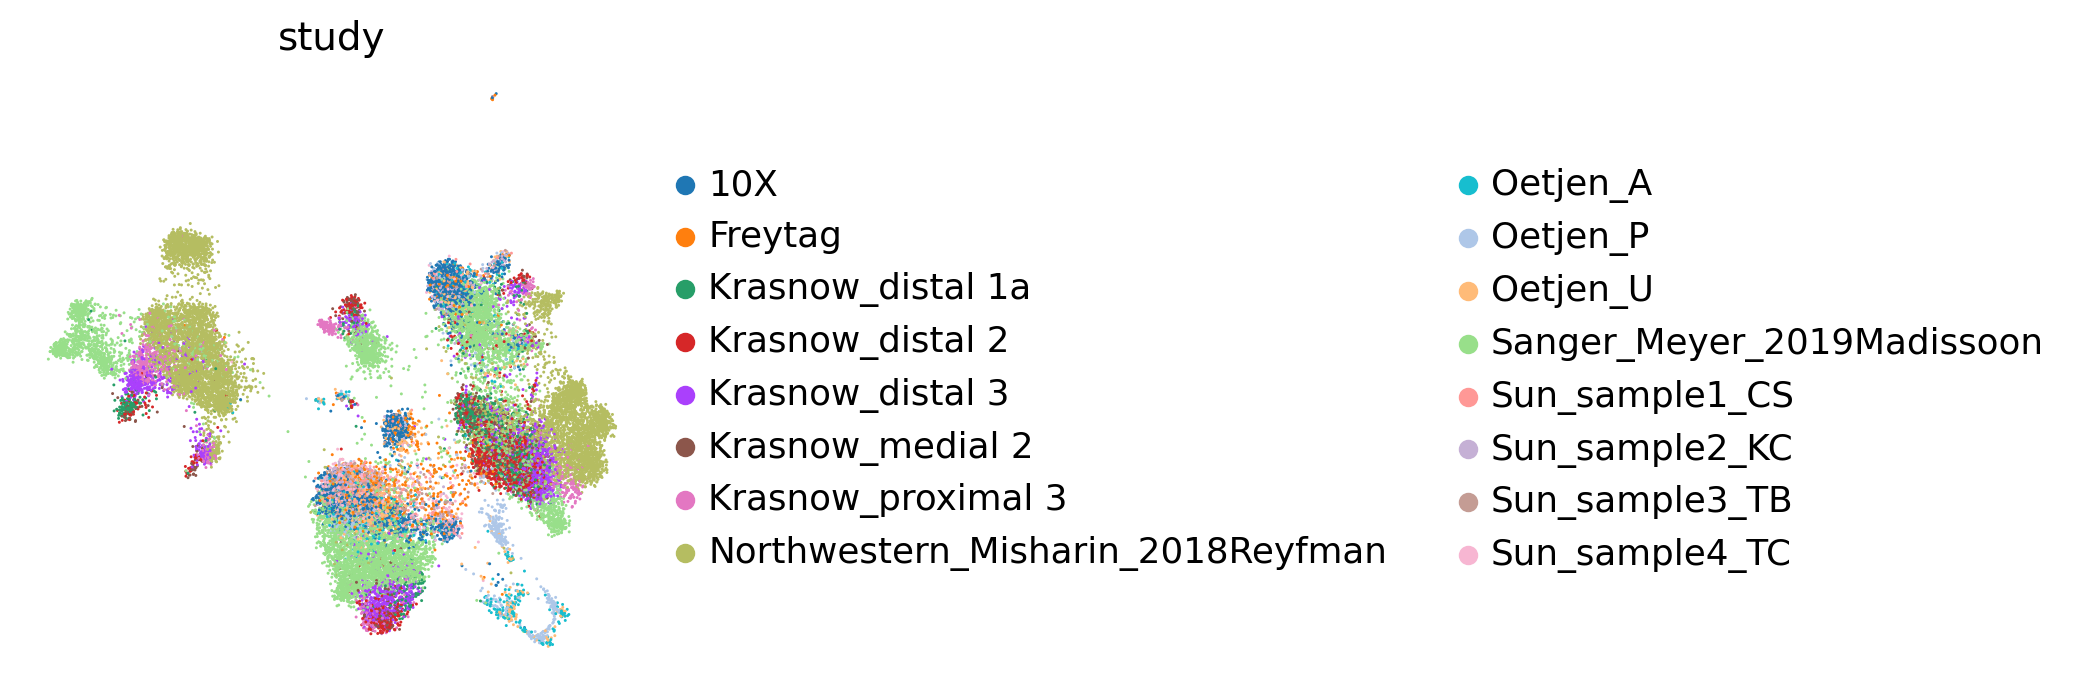

In [135]:
sc.pl.umap(ref_ss, color=['study'], frameon=False)

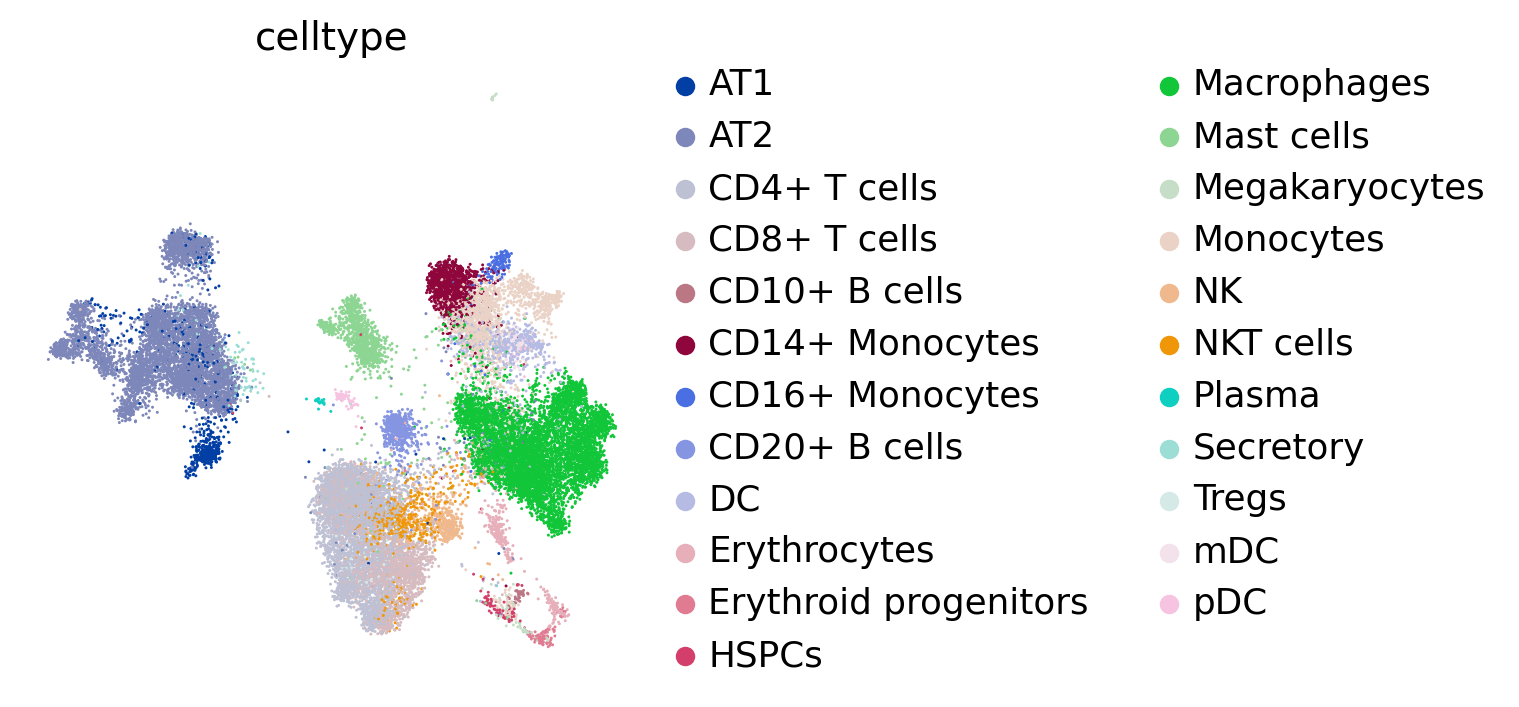

In [136]:
sc.pl.umap(ref_ss, color=['celltype'], frameon=False)

In [137]:
##### saving the model

In [141]:
name = "reference_covid_5k_new_3"

In [142]:
intr_cvae.save(name)

In [688]:
query = query[:, adata.var_names].copy()

In [144]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)

In [145]:
query.obs.sample_new.value_counts()

S2     16474
S1     11693
HC1     8429
HC2     8153
M1      3517
M2      3386
S6      2868
HC3     2555
S5      2041
S4      1705
S3      1292
M3       356
Name: sample_new, dtype: int64

#### Query training

In [686]:
query.obs.study = query.obs.sample_new.copy()

In [937]:
q_intr_cvae = sca.models.TRVAE.load_query_data(query, name)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 5000 545 28
	Hidden Layer 1 in/out: 545 545
	Mean/Var Layer in/out: 545 545
Encoder Architecture:
	Input Layer in, out and cond: 5000 128 28
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  545 5000 28


In [148]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
ALPHA = 0.5
EPOCHS = 400

In [157]:
q_intr_cvae.train(n_epochs=300, alpha_epoch_anneal=50, weight_decay=0.0,
                  alpha_kl=0.05, seed=2020,    alpha=None, 
 use_early_stopping=True, 
                  early_stopping_kwargs=early_stopping_kwargs)


 |████████------------| 44.7%  - epoch_loss: 2210.20 - epoch_recon_loss: 2195.66 - epoch_kl_loss:  290.92 - val_loss: 2017.96 - val_recon_loss: 2003.60 - val_kl_loss:  287.25
ADJUSTED LR
 |██████████----------| 52.0%  - epoch_loss: 2216.90 - epoch_recon_loss: 2202.33 - epoch_kl_loss:  291.40 - val_loss: 2017.90 - val_recon_loss: 2003.54 - val_kl_loss:  287.28
ADJUSTED LR
 |███████████---------| 59.3%  - epoch_loss: 2205.39 - epoch_recon_loss: 2190.85 - epoch_kl_loss:  290.89 - val_loss: 2017.80 - val_recon_loss: 2003.44 - val_kl_loss:  287.28
ADJUSTED LR
 |████████████--------| 63.7%  - epoch_loss: 2210.71 - epoch_recon_loss: 2196.16 - epoch_kl_loss:  290.95 - val_loss: 2016.97 - val_recon_loss: 2002.61 - val_kl_loss:  287.24
ADJUSTED LR
 |█████████████-------| 68.3%  - epoch_loss: 2220.93 - epoch_recon_loss: 2206.36 - epoch_kl_loss:  291.50 - val_loss: 2017.36 - val_recon_loss: 2003.00 - val_kl_loss:  287.28
ADJUSTED LR
 |██████████████------| 72.7%  - epoch_loss: 2206.81 - epoch_reco

In [181]:
q_intr_cvae.save("reference_covid_5k_new_3+query")

In [938]:
q_intr_cvae.load("reference_covid_5k_new_3+query",adata)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 5000 545 28
	Hidden Layer 1 in/out: 545 545
	Mean/Var Layer in/out: 545 545
Encoder Architecture:
	Input Layer in, out and cond: 5000 128 28
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  545 5000 28


#### Latent space for query data 

In [939]:
query.obsm['X_cvae'] = q_intr_cvae.get_latent(query.X.A, query.obs.study, mean=MEAN)[:, ~inactive_idx]

In [940]:
q_ss= sc.pp.subsample(query, copy=True, fraction=0.2)

In [941]:
sc.pp.neighbors(q_ss, use_rep='X_cvae')

In [942]:
sc.tl.umap(q_ss)

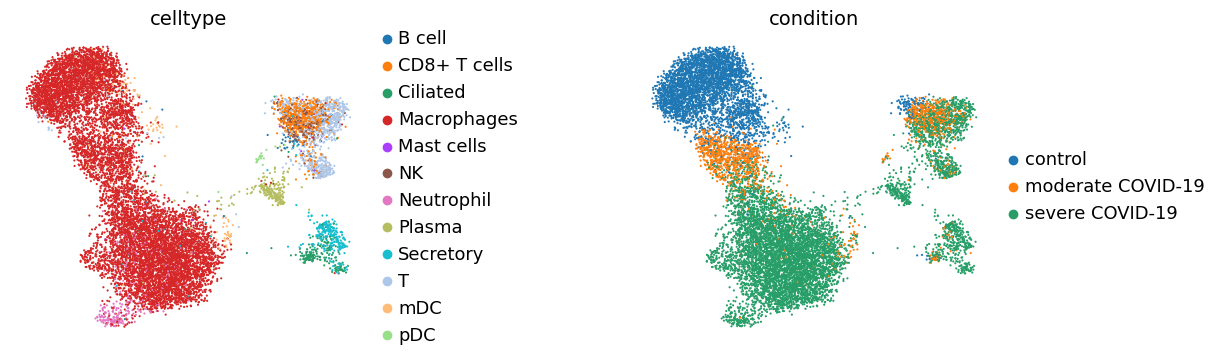

In [943]:
sc.pl.umap(q_ss, color=['celltype', 'condition'], frameon=False, wspace=0.6)

#### Joint embedding of query and the reference 

In [959]:
adata_all = sc.AnnData.concatenate(query, adata, batch_key='batch_join')

In [976]:
adata_all.obsm['X_cvae'] = q_intr_cvae.get_latent(adata_all.X.A, 
                                                  adata_all.obs['study'].tolist(),
                                                  mean=False)[:, ~inactive_idx]

In [977]:
adata_all_ss = sc.pp.subsample(adata_all, fraction=0.2, copy=True)

In [983]:
sc.pp.neighbors(adata_all_ss, use_rep='X_cvae', n_neighbors=20)
sc.tl.umap(adata_all_ss)

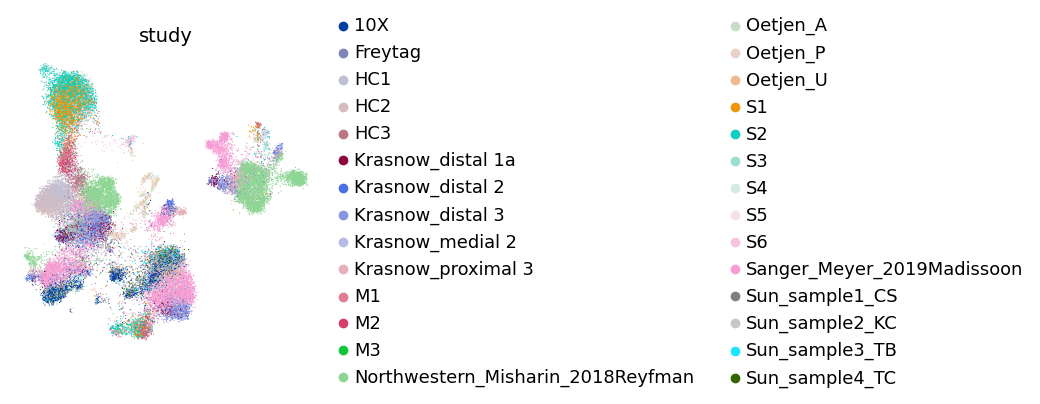

In [984]:
sc.pl.umap(adata_all_ss, color=['study'], frameon=False, wspace=0.6)

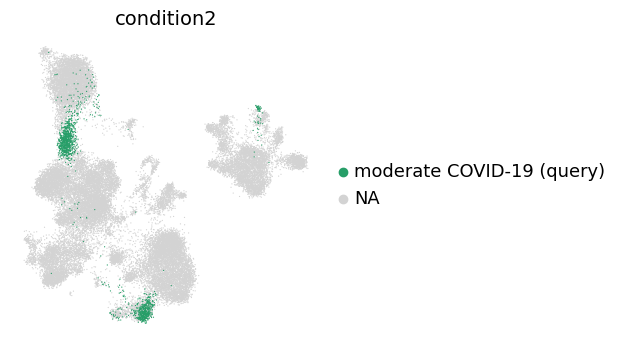

In [985]:
sc.pl.umap(adata_all_ss, color=['condition2'], groups=["moderate COVID-19 (query)"], frameon=False, wspace=0.6)

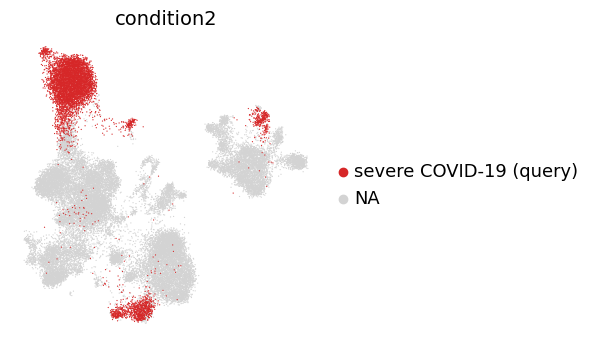

In [986]:
sc.pl.umap(adata_all_ss, color=['condition2'], groups=["severe COVID-19 (query)"], frameon=False, wspace=0.6)

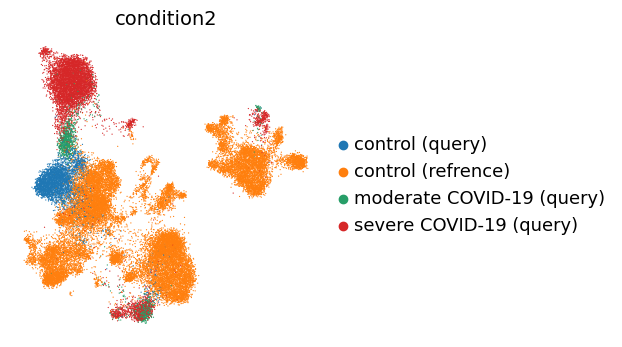

In [987]:
sc.pl.umap(adata_all_ss, color=['condition2'], frameon=False, wspace=0.6)

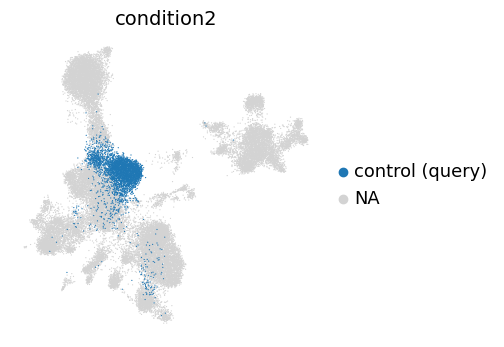

In [975]:
sc.pl.umap(adata_all_ss, color=['condition2'], groups=["control (query)"], frameon=False, wspace=0.6)

In [704]:
sc.pp.normalize_total(adata_raw)
sc.pp.log1p(adata_raw)

In [705]:
adata_all.raw = adata_raw

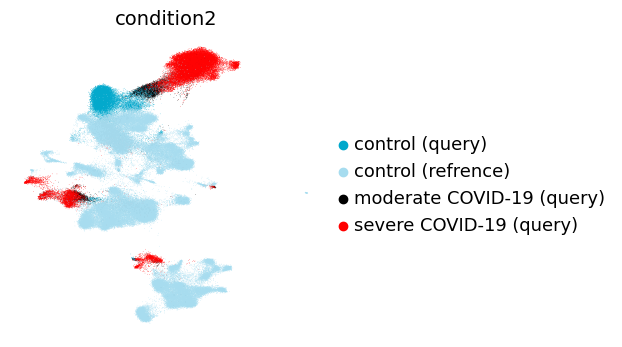

In [936]:
sc.pl.umap(adata_all, color=['condition2'], frameon=False, wspace=0.6)

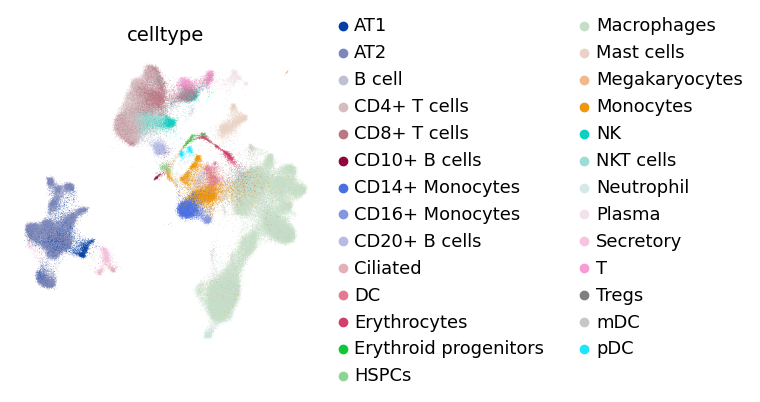

In [709]:
sc.pl.umap(adata_all, color=['celltype'], frameon=False, wspace=0.6)

### Diffrerential enrichment analysis

In [990]:
adata_all.obs.condition2 = adata_all.obs.condition2.astype('category')
adata_all.obs.condition = adata_all.obs.condition.astype('category')

In [991]:
adata_all.uns["terms"] = np.array(adata.uns["terms"])
# adata_all.uns["active_terms"] = np.array(adata.uns["active_terms"])
adata_all.uns['active_terms'] = np.array(adata.uns['terms'])[q_intr_cvae.model.decoder.nonzero_terms()]

### setting directions

In [992]:
directions = q_intr_cvae._latent_directions(method="sum")

In [993]:
adata_all.obsm['X_cvae']= adata_all.obsm['X_cvae'][:,q_intr_cvae.model.decoder.nonzero_terms()]

In [994]:
adata_all.obsm['X_cvae'] *= directions[q_intr_cvae.model.decoder.nonzero_terms()]

latent enrich for conditions for cell types 

In [995]:
adata_all.X = adata_all.X.A

In [996]:
scores_ct = q_intr_cvae.latent_enrich('celltype', comparison="rest",
                                        directions=directions, adata=adata_all,n_perm=10000)

In [997]:
scores_cond = q_intr_cvae.latent_enrich('condition', comparison="control",
                                        directions=directions, adata=adata_all,n_perm=10000)

helper function to filter pathways according to bayse factor

In [998]:
def filter_set_scores(scores, adata, filter_v=2.31):
    score_dict = {}
    for k in scores:
        score_dict[k] = {}
        mask = np.abs(scores[k]['bf']) > filter_v
        s = sum(mask)
        if s > 0:
            sort = np.argsort(np.abs(scores[k]['bf'])[mask])[::-1]
            enriched_terms = adata.uns['terms'][mask][sort]
            score_dict[k]["terms"] = enriched_terms
            score_dict[k]["scores"] = scores[k]['bf'][mask][sort]
#             print(enriched_terms)
#             print(scores[k]['bf'][mask][sort])
            for term in enriched_terms:
                adata.obs[term] = adata.obsm['X_cvae'][:, adata.uns['active_terms'] == term]
    return score_dict

In [999]:
path_ways_ct = filter_set_scores(scores_ct, adata_all, filter_v=1.8)

In [1008]:
path_ways_cond = filter_set_scores(scores_cond, adata_all, filter_v=1.5)

In [1011]:
path_ways_cond

{'moderate COVID-19': {'terms': array(['REACTOME_INTERFERON_SIGNALING',
         'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
         'REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES',
         'REACTOME_NONSENSE_MEDIATED_DECAY_ENHANCED_BY_THE_EXON_JUNCTION_COMPLEX',
         'REACTOME_METABOLISM_OF_PROTEINS'], dtype='<U132'),
  'scores': array([ 4.35,  3.08,  1.6 , -1.56, -1.55])},
 'severe COVID-19': {'terms': array(['REACTOME_INTERFERON_SIGNALING',
         'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
         'REACTOME_METABOLISM_OF_PROTEINS',
         'REACTOME_TCA_CYCLE_AND_RESPIRATORY_ELECTRON_TRANSPORT',
         'REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES',
         'REACTOME_CLASS_A1_RHODOPSIN_LIKE_RECEPTORS'], dtype='<U132'),
  'scores': array([ 4.37,  2.94, -2.36, -2.02,  1.8 ,  1.53])}}

ploting diff pathwayys per condition

... storing 'age_range' as categorical


moderate COVID-19


... storing 'anatomical_region' as categorical
... storing 'batch' as categorical
... storing 'dataset' as categorical
... storing 'donor' as categorical
... storing 'ethnicity' as categorical
... storing 'last_author/PI' as categorical
... storing 'lung_vs_nasal' as categorical
... storing 'original_celltype_ann' as categorical
... storing 'pack_years' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'smoking' as categorical
... storing 'ann_level_1' as categorical
... storing 'ann_level_2' as categorical
... storing 'ann_level_3' as categorical
... storing 'ann_level_4' as categorical
... storing 'ann_level_5' as categorical
... storing 'ann_new' as categorical
... storing 'subject_type' as categorical
... storing 'study' as categorical
... storing 'study2' as categorical
... storing 'celltype' as categorical
... storing 'ID' as categorical
... storing 'sample_new' as categorical
... storing 'chemistry' as categorical
... storing 'data_t

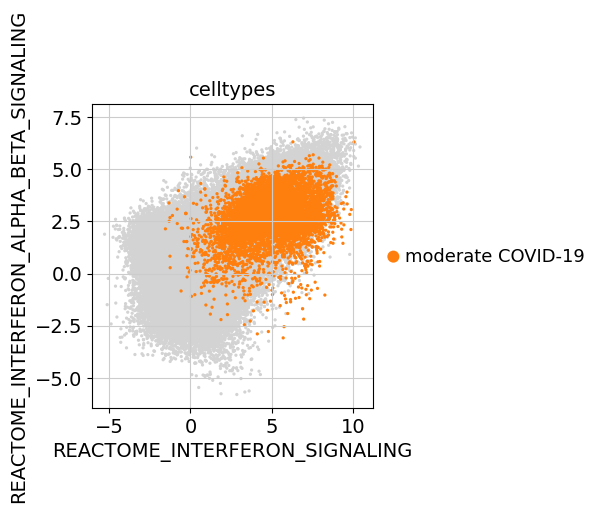

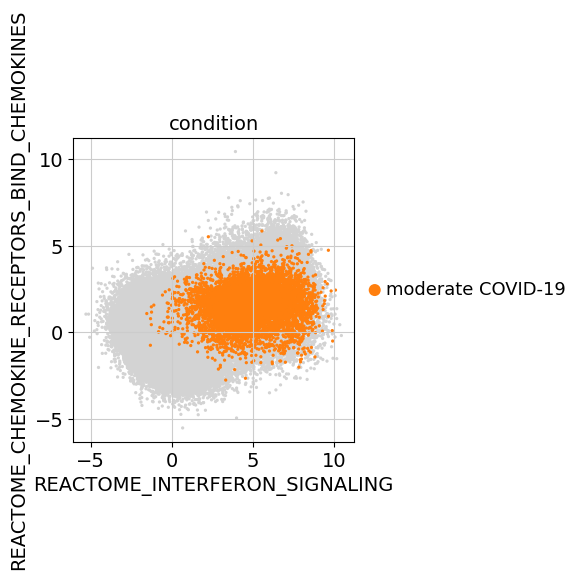

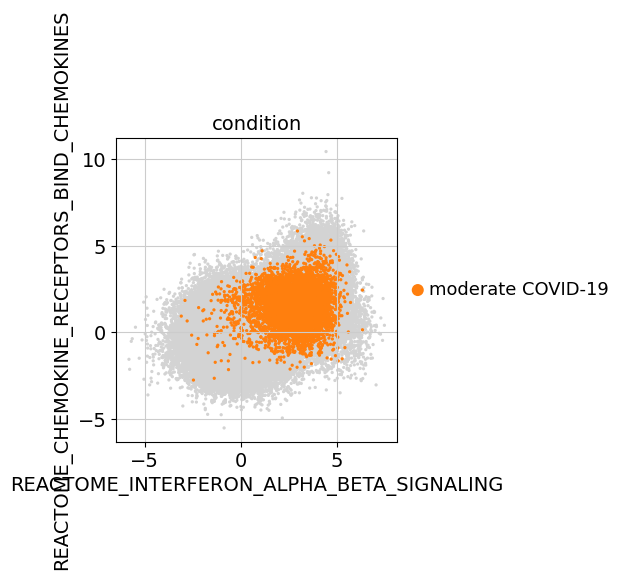

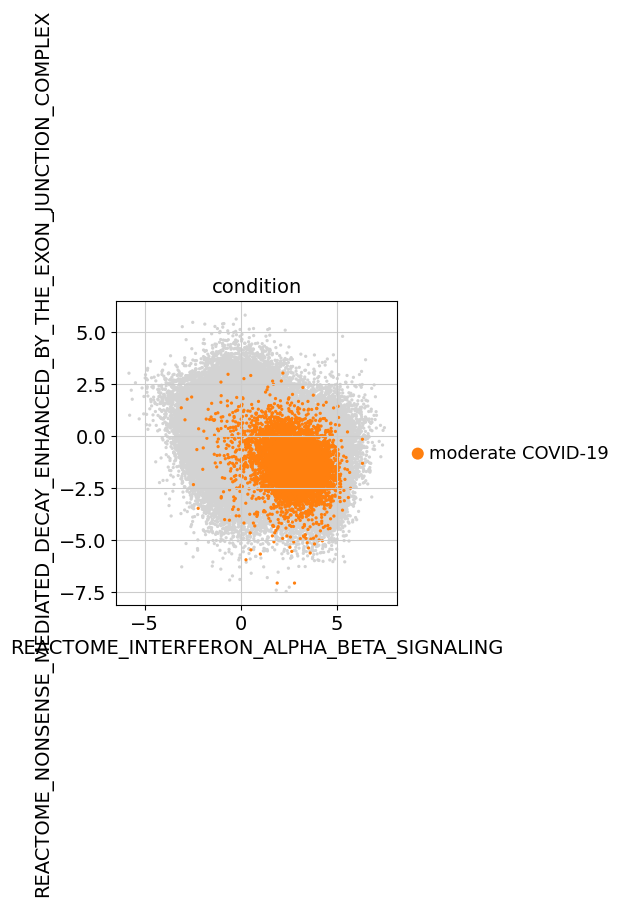

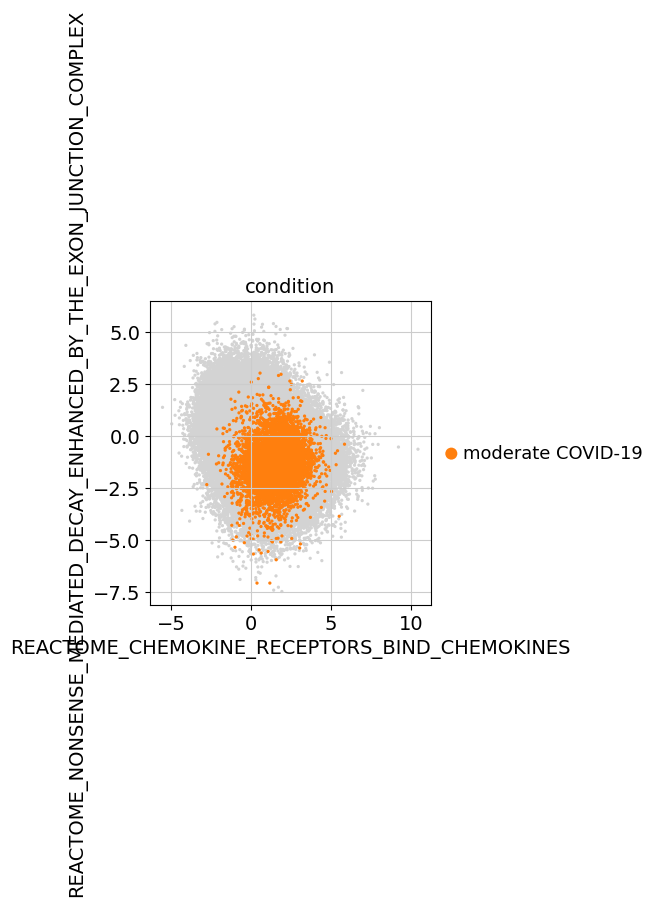

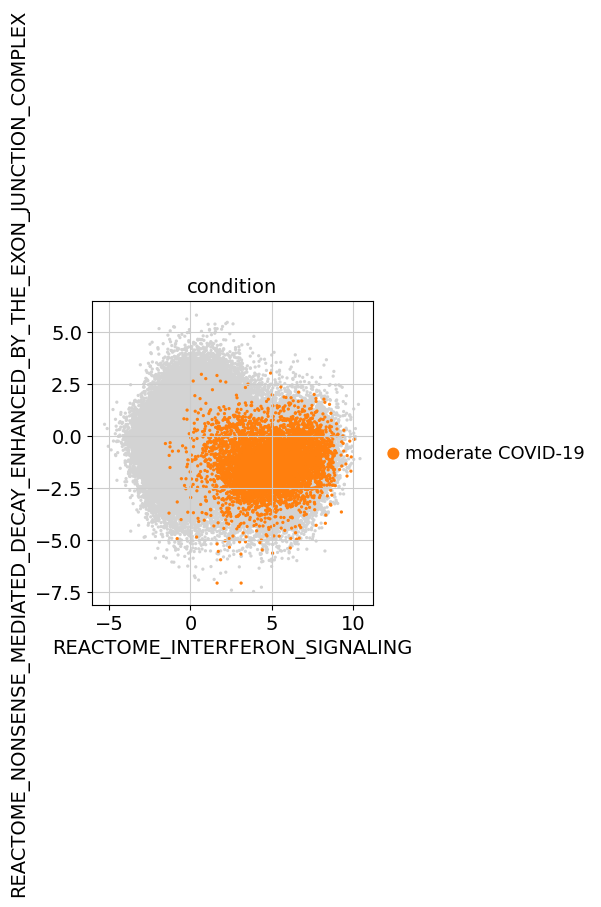

severe COVID-19


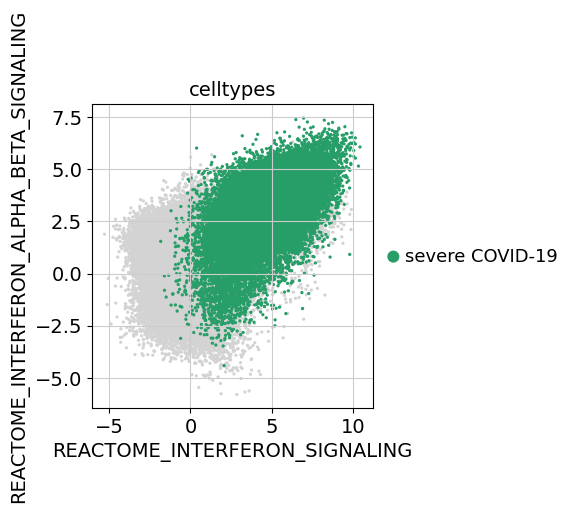

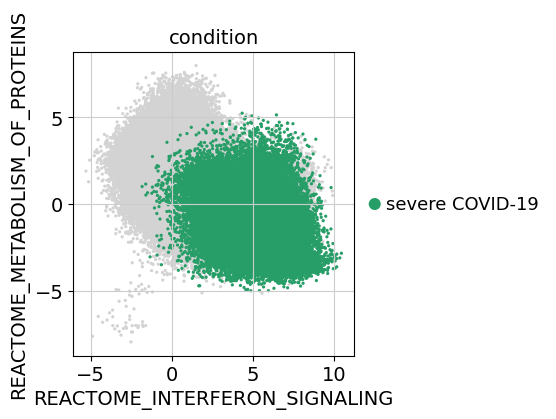

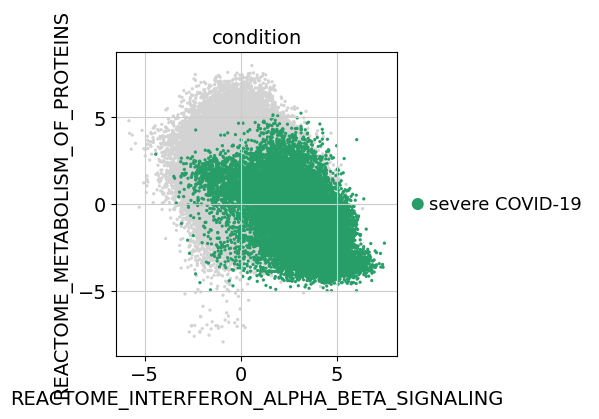

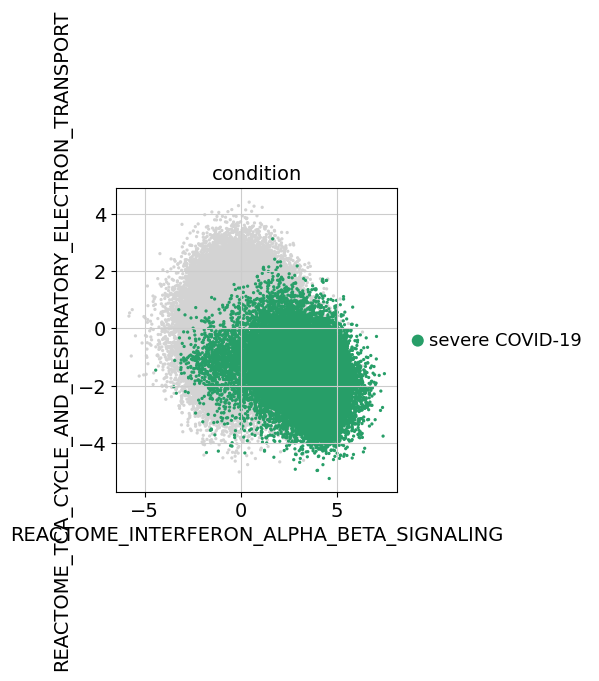

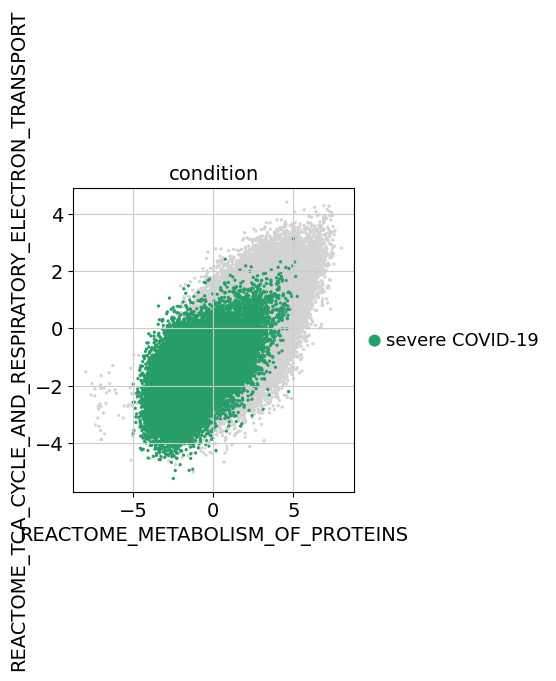

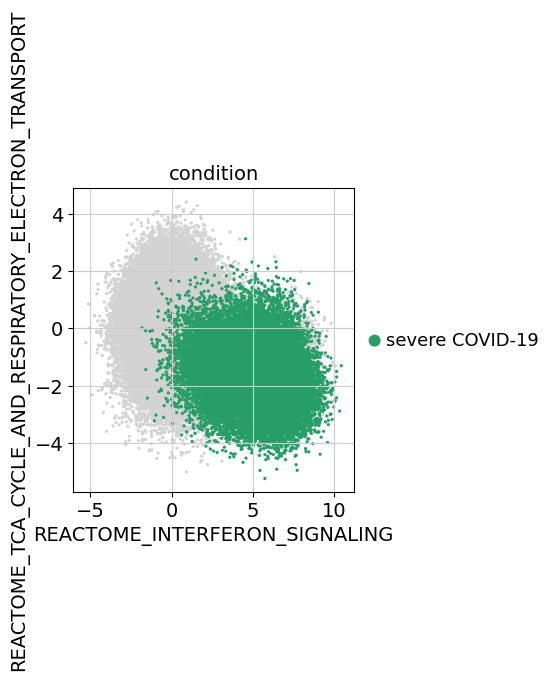

In [1010]:
for ct in path_ways_cond.keys():
    if(len(path_ways_cond[ct]))<1:
        continue
    if len(path_ways_cond[ct]["terms"]) >=2:
        print(ct)
        sc.pl.scatter(adata_all, x=path_ways_cond[ct]["terms"][0], y=path_ways_cond[ct]["terms"][1], 
              color='condition', size=22, title='celltypes', groups=f"{ct}")
        if len(path_ways_cond[ct]["terms"]) >2:
            sc.pl.scatter(adata_all, x=path_ways_cond[ct]["terms"][0], y=path_ways_cond[ct]["terms"][2], 
          color='condition', size=22, title='condition', groups=f"{ct}")
            sc.pl.scatter(adata_all, x=path_ways_cond[ct]["terms"][1], y=path_ways_cond[ct]["terms"][2], 
          color='condition', size=22, title='condition', groups=f"{ct}")
    if len(path_ways_cond[ct]["terms"]) >3:
                    sc.pl.scatter(adata_all, x=path_ways_cond[ct]["terms"][1], y=path_ways_cond[ct]["terms"][3], 
          color='condition', size=22, title='condition', groups=f"{ct}")
                    sc.pl.scatter(adata_all, x=path_ways_cond[ct]["terms"][2], y=path_ways_cond[ct]["terms"][3], 
          color='condition', size=22, title='condition', groups=f"{ct}")
                    sc.pl.scatter(adata_all, x=path_ways_cond[ct]["terms"][0], y=path_ways_cond[ct]["terms"][3], 
          color='condition', size=22, title='condition', groups=f"{ct}")
                    
            


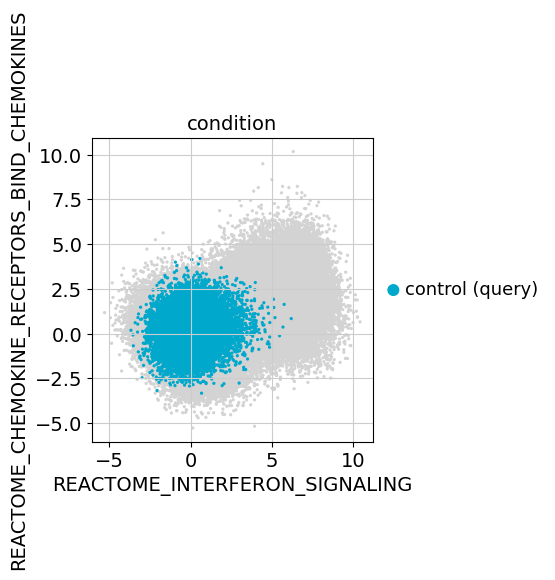

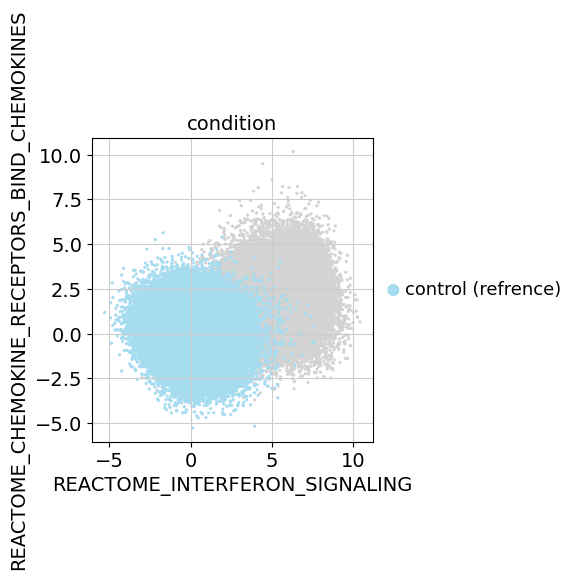

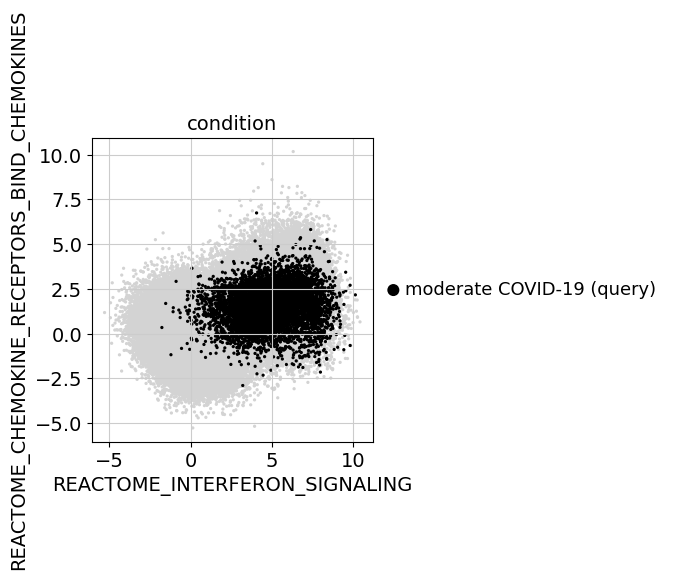

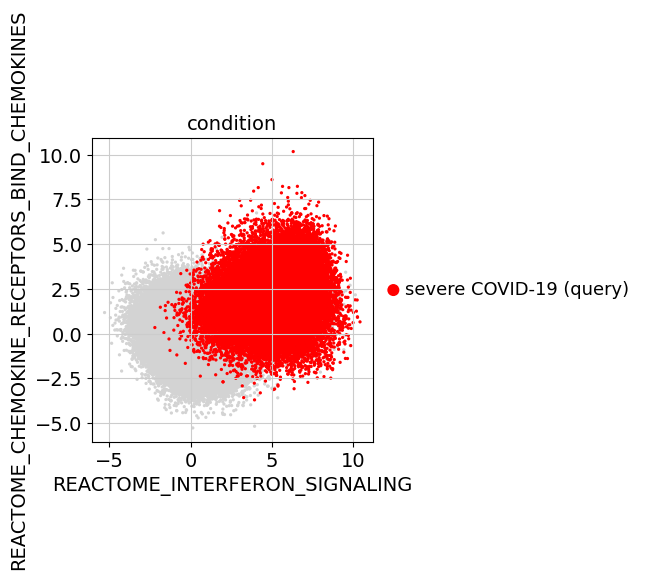

In [924]:
for i in  np.unique(adata_all.obs.condition2):
       sc.pl.scatter(adata_all, x="REACTOME_INTERFERON_SIGNALING", 
                  y="REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES", 
          color='condition2', size=22, title='condition'
                  , groups=f"{i}", palette=["#00a8cc","#a6dcef","black","red"],save=f"_{i}_pert")

#### celltype pathways for all cell types in the query data to determine the response

In [ ]:
for i in query.obs.celltype.unique():
        sc.pl.scatter(adata_all, x="REACTOME_INTERFERON_SIGNALING", 
                  y="REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES", 
          color='celltype', size=22, title='condition'
                  , groups=f"{i}", legend_loc="on data", save=f"{i}", show=False)

#### celltype pathways for all cell types in  query to determine the cell types

In [ ]:
for ct in query.obs.celltype.unique():
    if(len(path_ways_ct[ct]))<1:
        continue
    if len(path_ways_ct[ct]["terms"]) >=2:
        sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][0], y=path_ways_ct[ct]["terms"][1], 
              color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data", show=False, save=f"_{ct}_re+q_v1")
        if len(path_ways_ct[ct]["terms"]) >2:
            sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][0], y=path_ways_ct[ct]["terms"][2], 
          color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data", show=False, save=f"_{ct}_re+q_v2")
            sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][1], y=path_ways_ct[ct]["terms"][2], 
          color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data", show=False, save=f"_{ct}_re+q_v3")

embedding for all cell types in query an reference

In [929]:
for ct in path_ways_ct.keys():
    if(len(path_ways_ct[ct]))<1:
        continue
    if len(path_ways_ct[ct]["terms"]) >=2:
        sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][0], y=path_ways_ct[ct]["terms"][1], 
              color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data", show=False, save=f"_{ct}_re+q_v1")
        if len(path_ways_ct[ct]["terms"]) >2:
            sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][0], y=path_ways_ct[ct]["terms"][2], 
          color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data", show=False, save=f"_{ct}_re+q_v2")
            sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][1], y=path_ways_ct[ct]["terms"][2], 
          color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data", show=False, save=f"_{ct}_re+q_v3")

In [902]:
query.obs.celltype.value_counts()

Macrophages     48734
T                3717
CD8+ T cells     2771
Neutrophil       1607
Secretory        1267
NK               1113
Plasma           1041
mDC               941
Ciliated          881
B cell            198
pDC               148
Mast cells         51
Name: celltype, dtype: int64

{'terms': array(['REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION',
       'REACTOME_ANTIGEN_ACTIVATES_B_CELL_RECEPTOR_LEADING_TO_GENERATION_OF_SECOND_MESSENGERS',
       'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR'], dtype='<U132'), 'scores': array([-3.17,  2.36, -1.91])}


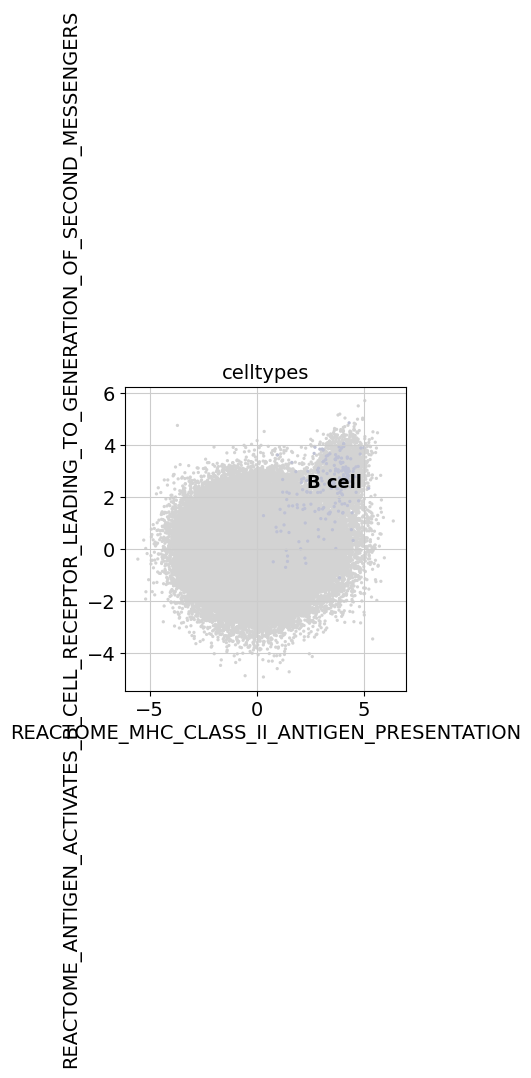

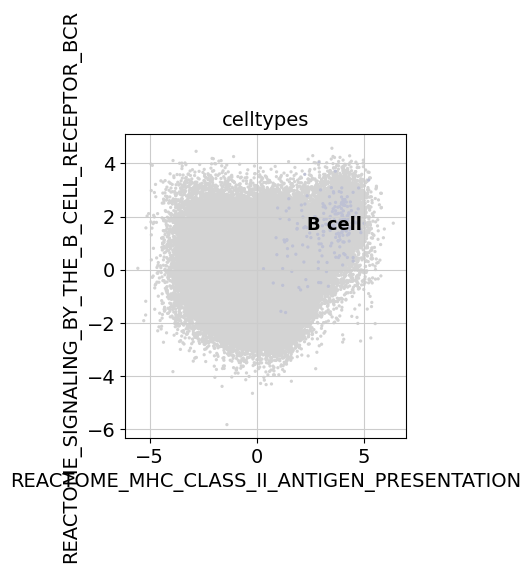

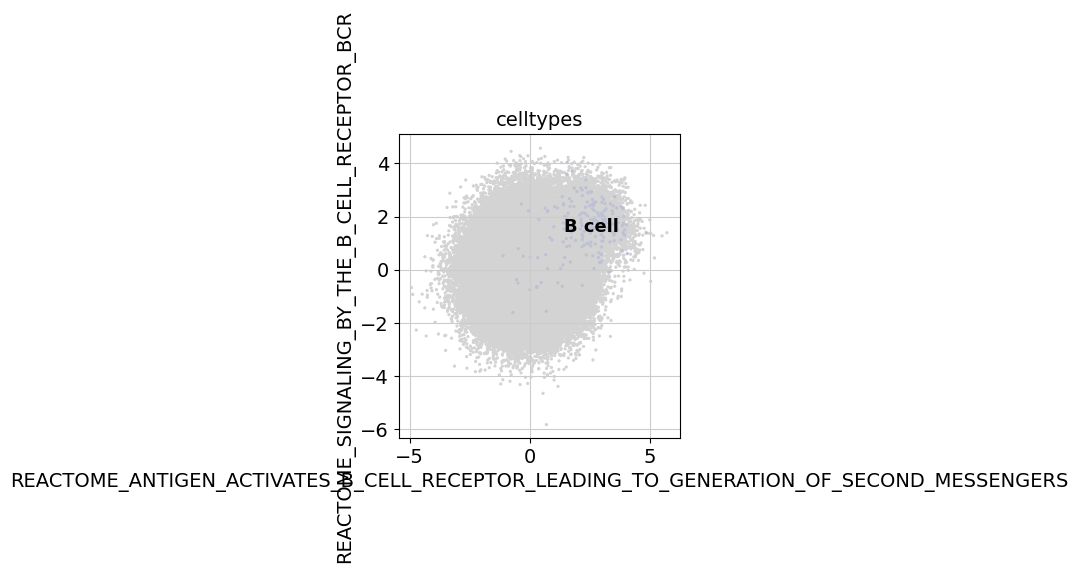

{'terms': array(['REACTOME_TRANSMEMBRANE_TRANSPORT_OF_SMALL_MOLECULES',
       'REACTOME_IMMUNE_SYSTEM',
       'REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS',
       'REACTOME_DEVELOPMENTAL_BIOLOGY',
       'REACTOME_METABOLISM_OF_AMINO_ACIDS_AND_DERIVATIVES',
       'REACTOME_MEMBRANE_TRAFFICKING', 'REACTOME_HEMOSTASIS',
       'REACTOME_DIABETES_PATHWAYS',
       'REACTOME_PROCESSING_OF_CAPPED_INTRON_CONTAINING_PRE_MRNA',
       'REACTOME_METABOLISM_OF_MRNA'], dtype='<U132'), 'scores': array([ 3.26,  2.77,  2.5 , -2.25, -2.24, -2.22, -1.96,  1.95, -1.89,
       -1.88])}


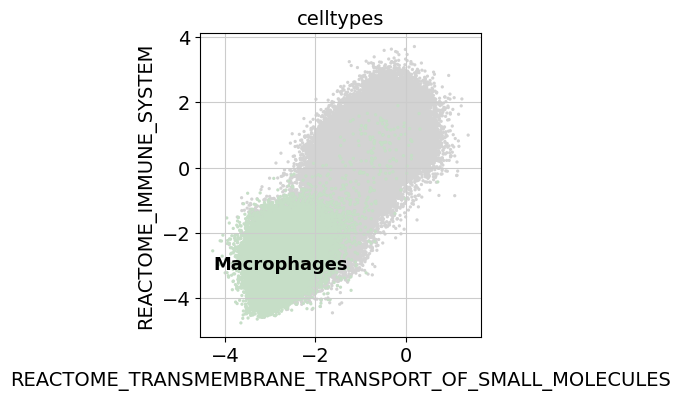

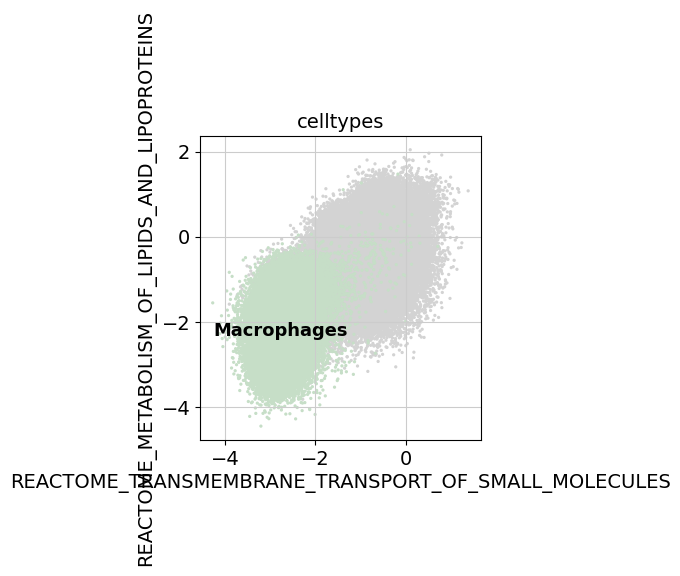

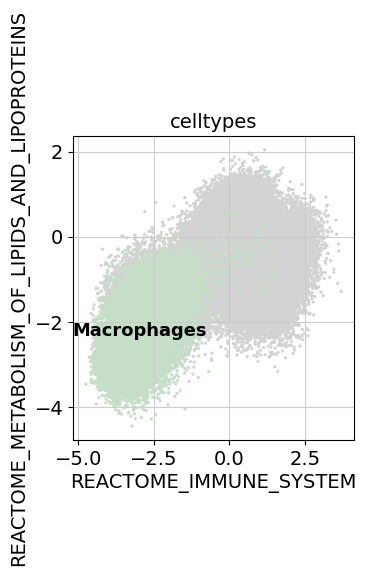

{'terms': array(['REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN_TARGETING_TO_MEMBRANE',
       'REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION',
       'REACTOME_IL_3_5_AND_GM_CSF_SIGNALING',
       'REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS',
       'REACTOME_SPHINGOLIPID_METABOLISM',
       'REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM',
       'REACTOME_GLYCEROPHOSPHOLIPID_BIOSYNTHESIS'], dtype='<U132'), 'scores': array([ 2.86, -2.24,  2.21, -2.19,  2.16,  2.07,  1.91])}


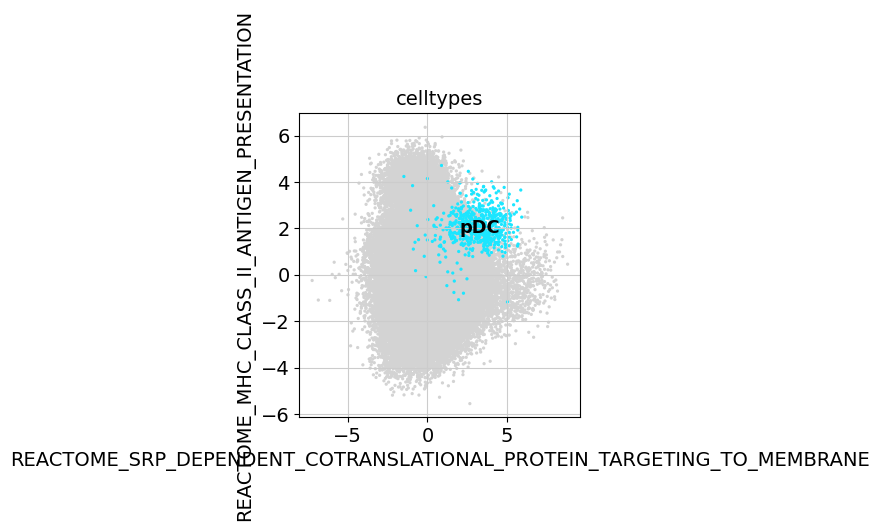

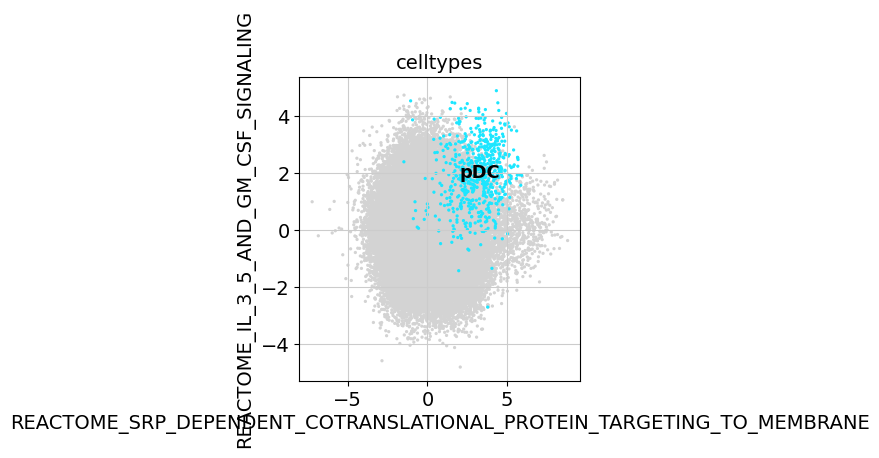

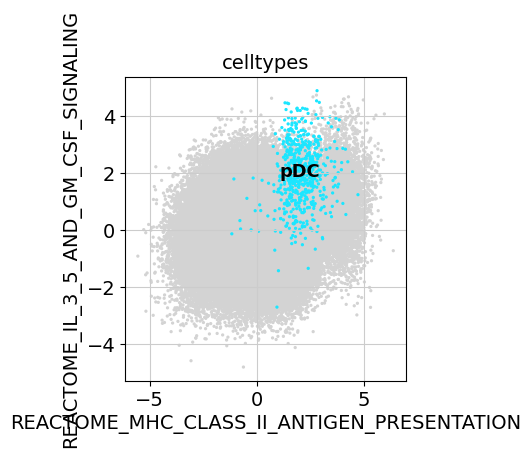

{'terms': array(['REACTOME_UNFOLDED_PROTEIN_RESPONSE',
       'REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN_TARGETING_TO_MEMBRANE',
       'REACTOME_COLLAGEN_FORMATION',
       'REACTOME_3_UTR_MEDIATED_TRANSLATIONAL_REGULATION',
       'REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION',
       'REACTOME_ASPARAGINE_N_LINKED_GLYCOSYLATION'], dtype='<U132'), 'scores': array([-3.64,  2.97, -2.64,  2.25,  1.93, -1.86])}


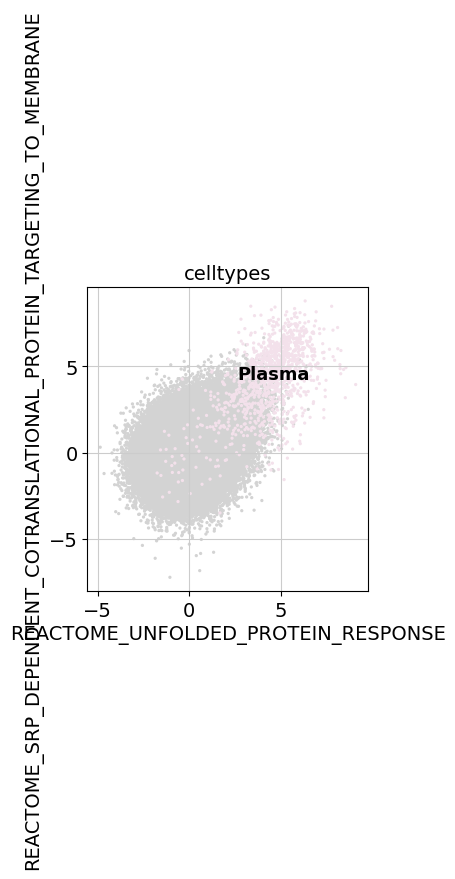

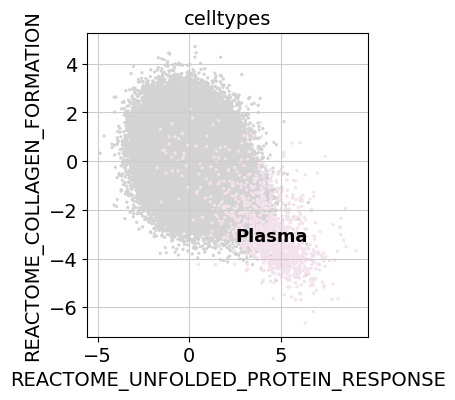

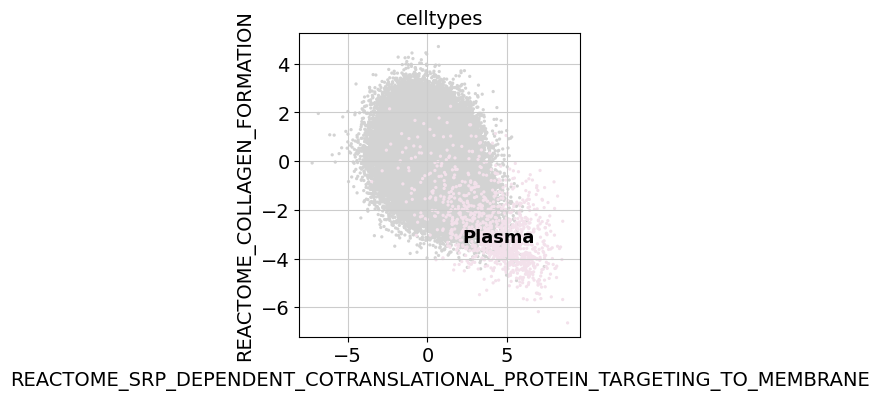

{'terms': array(['REACTOME_SIGNALING_BY_SCF_KIT',
       'REACTOME_GASTRIN_CREB_SIGNALLING_PATHWAY_VIA_PKC_AND_MAPK',
       'REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION',
       'REACTOME_RESPONSE_TO_ELEVATED_PLATELET_CYTOSOLIC_CA2_',
       'REACTOME_PHASE1_FUNCTIONALIZATION_OF_COMPOUNDS',
       'REACTOME_AXON_GUIDANCE'], dtype='<U132'), 'scores': array([-3.05, -2.42,  2.38, -2.32,  2.04, -1.95])}


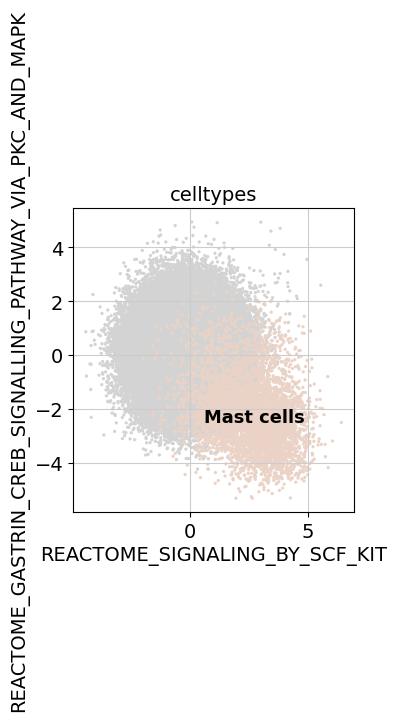

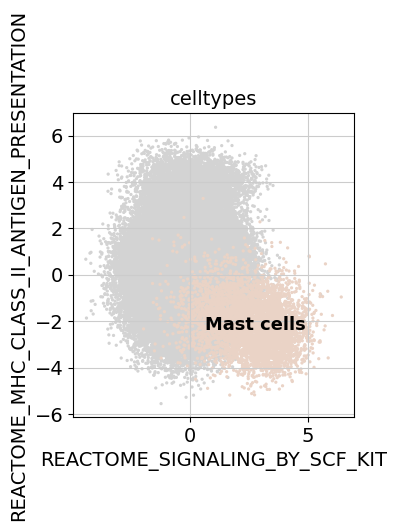

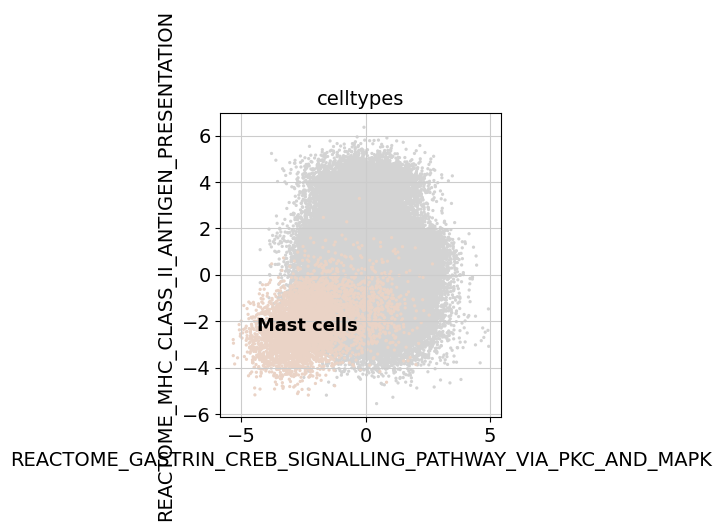

{'terms': array(['REACTOME_METABOLISM_OF_PROTEINS',
       'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
       'REACTOME_INTERFERON_SIGNALING', 'REACTOME_CIRCADIAN_CLOCK',
       'REACTOME_RNA_POL_I_RNA_POL_III_AND_MITOCHONDRIAL_TRANSCRIPTION',
       'REACTOME_RESPIRATORY_ELECTRON_TRANSPORT',
       'REACTOME_TCA_CYCLE_AND_RESPIRATORY_ELECTRON_TRANSPORT',
       'REACTOME_PLATELET_ACTIVATION_SIGNALING_AND_AGGREGATION',
       'REACTOME_CLASS_A1_RHODOPSIN_LIKE_RECEPTORS'], dtype='<U132'), 'scores': array([-3.14, -2.98,  2.4 , -2.19,  2.19,  1.94, -1.93,  1.92, -1.83])}


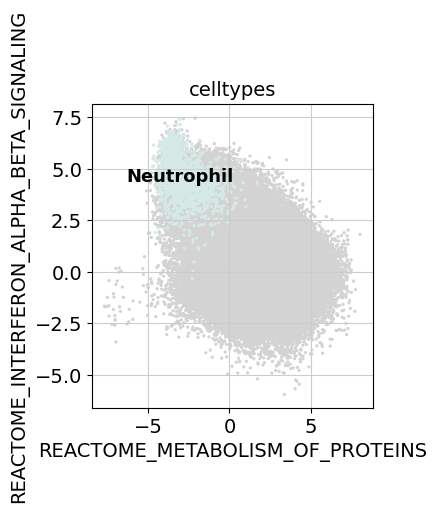

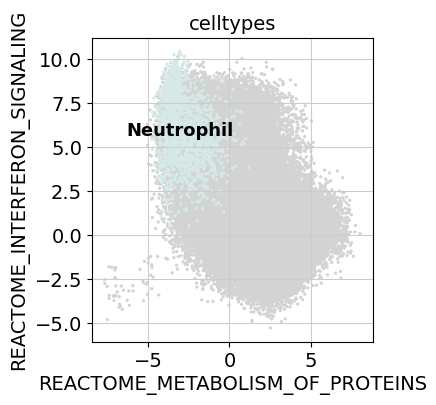

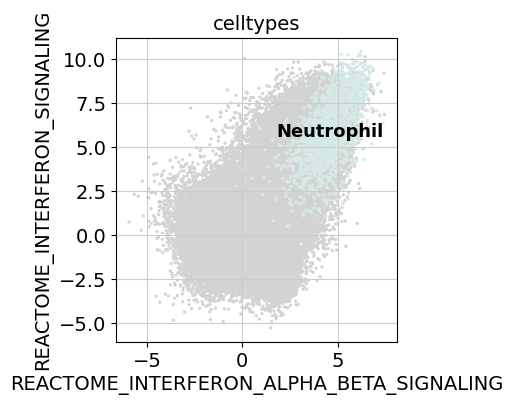

{'terms': array(['REACTOME_IMMUNE_SYSTEM',
       'REACTOME_CELL_SURFACE_INTERACTIONS_AT_THE_VASCULAR_WALL',
       'REACTOME_GPCR_LIGAND_BINDING',
       'REACTOME_PLATELET_ACTIVATION_SIGNALING_AND_AGGREGATION',
       'REACTOME_SIGNALING_BY_GPCR'], dtype='<U132'), 'scores': array([-2.24,  2.03,  2.03, -2.01,  1.96])}


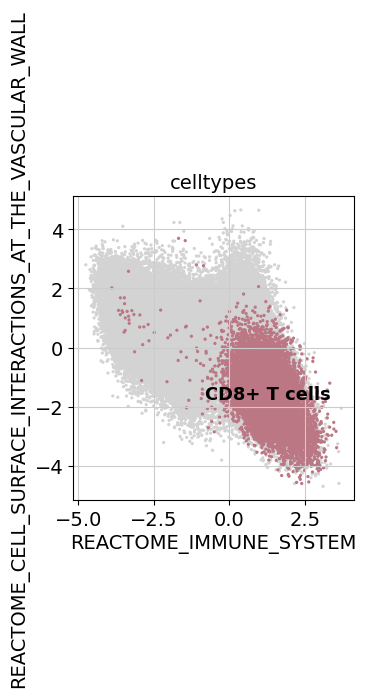

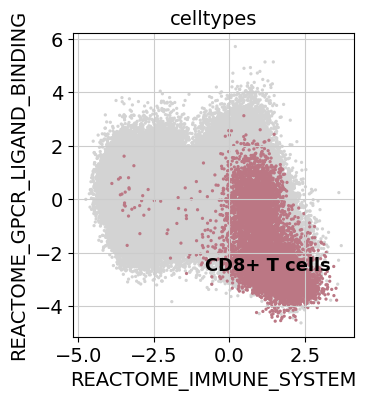

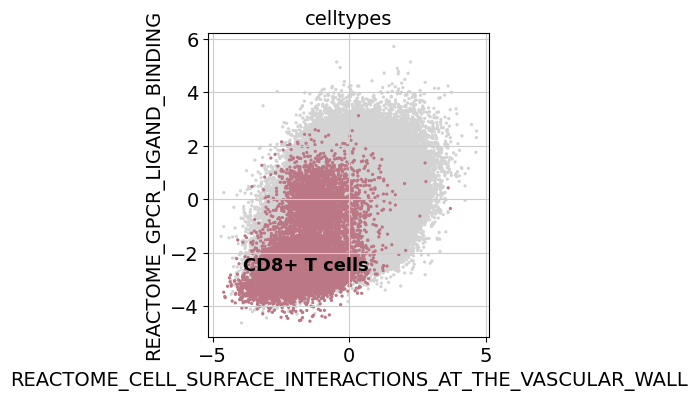

{'terms': array(['REACTOME_GLUTATHIONE_CONJUGATION',
       'REACTOME_DEVELOPMENTAL_BIOLOGY',
       'REACTOME_CELL_CELL_COMMUNICATION',
       'REACTOME_RECRUITMENT_OF_MITOTIC_CENTROSOME_PROTEINS_AND_COMPLEXES',
       'REACTOME_HEMOSTASIS'], dtype='<U132'), 'scores': array([-2.38,  2.31, -2.21,  1.91,  1.8 ])}


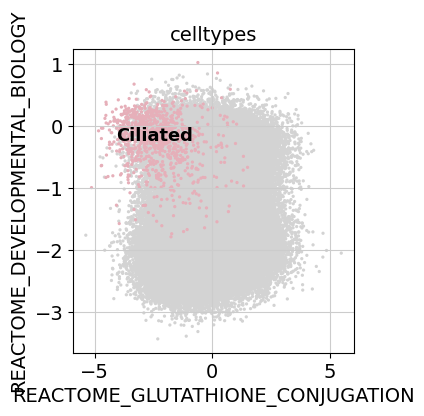

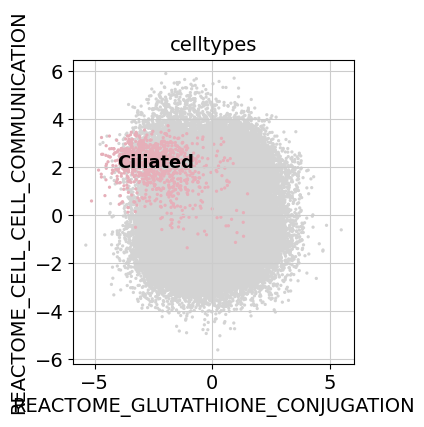

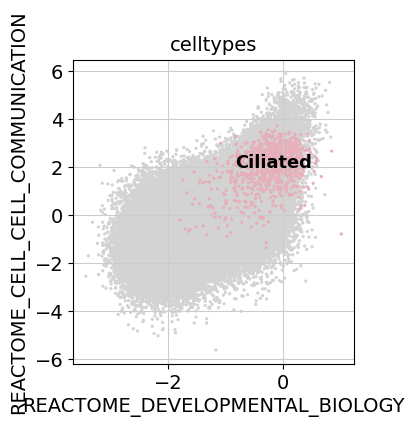

{'terms': array(['REACTOME_CELL_CELL_COMMUNICATION',
       'REACTOME_BIOLOGICAL_OXIDATIONS', 'REACTOME_DEVELOPMENTAL_BIOLOGY',
       'REACTOME_APOPTOSIS', 'REACTOME_HEMOSTASIS'], dtype='<U132'), 'scores': array([-2.35, -2.07,  2.06,  1.99,  1.89])}


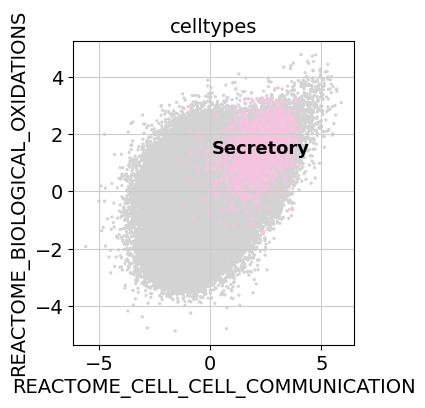

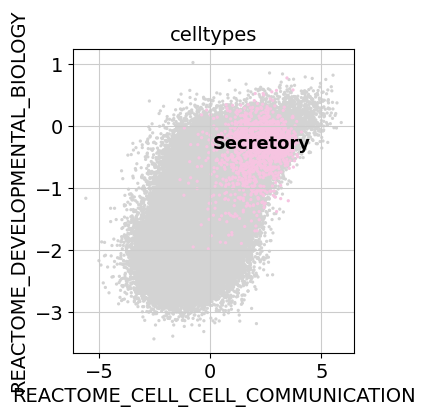

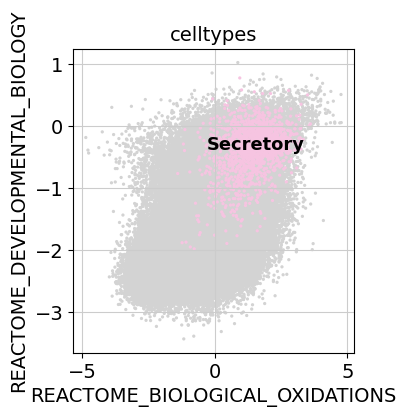

In [901]:
for ct in query.obs.celltype.unique():
    if(len(path_ways_ct[ct]))<1:
        continue
    if len(path_ways_ct[ct]["terms"]) >=2:
        print(path_ways_ct[ct])
        sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][0], y=path_ways_ct[ct]["terms"][1], 
              color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data")
        if len(path_ways_ct[ct]["terms"]) >2:
            sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][0], y=path_ways_ct[ct]["terms"][2], 
          color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data")
            sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][1], y=path_ways_ct[ct]["terms"][2], 
          color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data")

In [757]:
# macrophages 

In [758]:
macro = adata_all[adata_all.obs.celltype == "Macrophages"]

In [759]:
adata_all.raw = adata_raw

In [765]:
scores_mac = q_intr_cvae.latent_enrich('condition', comparison="control",
                                        directions=directions, adata=macro,n_perm=7000)

In [766]:
macro_list = filter_set_scores(scores_mac, macro,2)

In [767]:
macro_list

{'moderate COVID-19': {'terms': array(['REACTOME_INTERFERON_SIGNALING',
         'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
         'REACTOME_NONSENSE_MEDIATED_DECAY_ENHANCED_BY_THE_EXON_JUNCTION_COMPLEX',
         'REACTOME_METABOLISM_OF_PROTEINS'], dtype='<U132'),
  'scores': array([ 4.88,  4.62, -2.22, -2.04])},
 'severe COVID-19': {'terms': array(['REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
         'REACTOME_INTERFERON_SIGNALING', 'REACTOME_METABOLISM_OF_PROTEINS',
         'REACTOME_TOLL_RECEPTOR_CASCADES',
         'REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS',
         'REACTOME_SIGNALING_BY_GPCR',
         'REACTOME_CLASS_A1_RHODOPSIN_LIKE_RECEPTORS',
         'REACTOME_RESPONSE_TO_ELEVATED_PLATELET_CYTOSOLIC_CA2_',
         'REACTOME_TCA_CYCLE_AND_RESPIRATORY_ELECTRON_TRANSPORT',
         'REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM',
         'REACTOME_FATTY_ACID_TRIACYLGLYCEROL_AND_KETONE_BODY_METABOLISM',
         'REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES',
     

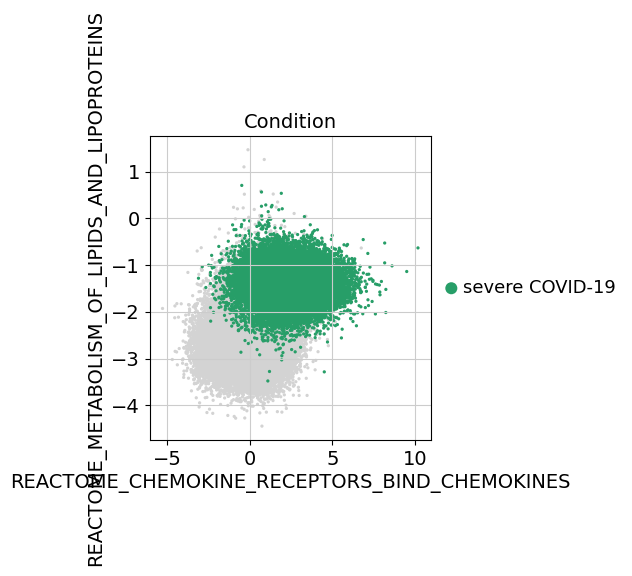

In [769]:
sc.pl.scatter(macro, x='REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES', y='REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', 
              color='condition', size=22, title='Condition', groups="severe COVID-19")

In [616]:
sc.pl.scatter(macro, x='REACTOME_TOLL_RECEPTOR_CASCADES', y='REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', 
              color='CCL2', size=22, title='Condition', groups="moderate COVID-19",)

TypeError: scatter() got an unexpected keyword argument 'vmax'

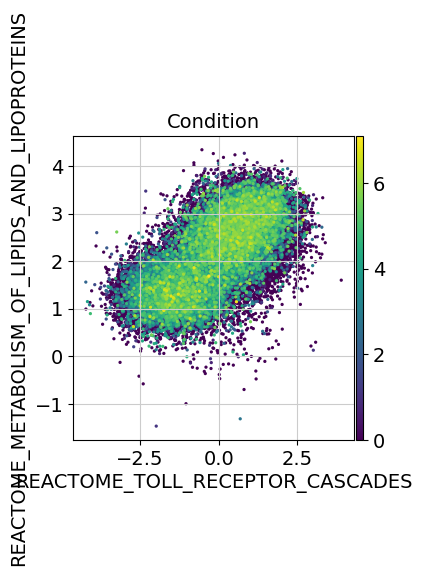

In [613]:
sc.pl.scatter(macro, x='REACTOME_TOLL_RECEPTOR_CASCADES', y='REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', 
              color='FABP4', size=22, title='Condition', groups="moderate COVID-19")

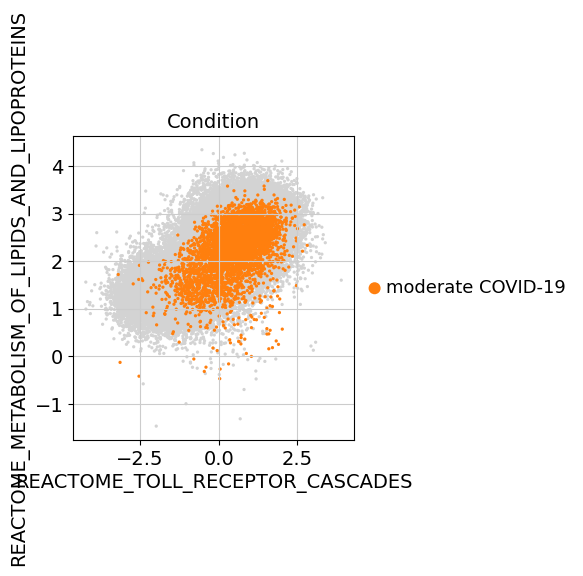

In [611]:
sc.pl.scatter(macro, x='REACTOME_TOLL_RECEPTOR_CASCADES', y='REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', 
              color='condition', size=22, title='Condition', groups="moderate COVID-19")

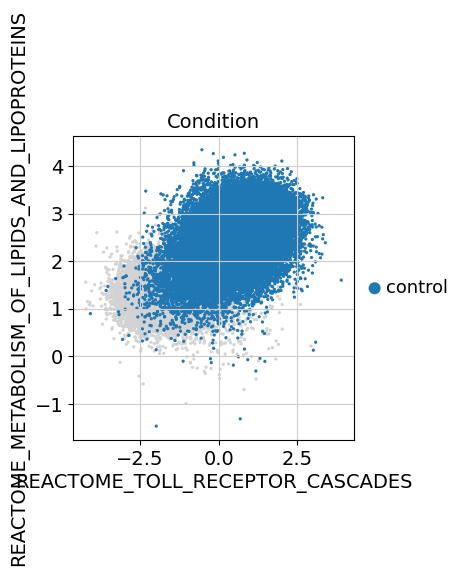

In [612]:
sc.pl.scatter(macro, x='REACTOME_TOLL_RECEPTOR_CASCADES', y='REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', 
              color='condition', size=22, title='Condition', groups="control")

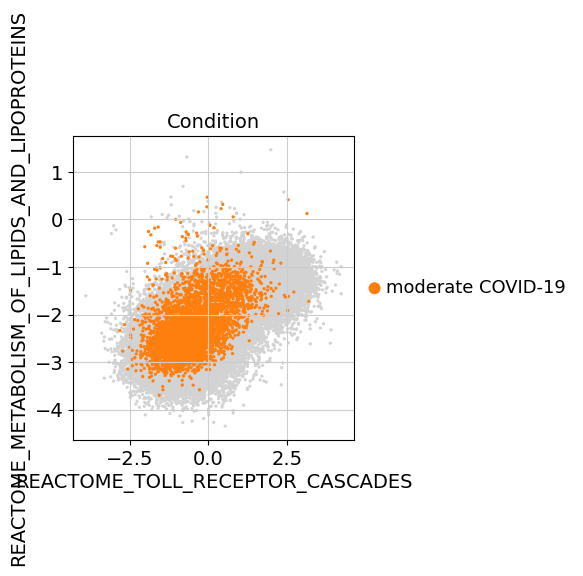

In [512]:
sc.pl.scatter(macro, x='REACTOME_TOLL_RECEPTOR_CASCADES', y='REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', 
              color='condition', size=22, title='Condition', groups="moderate COVID-19")

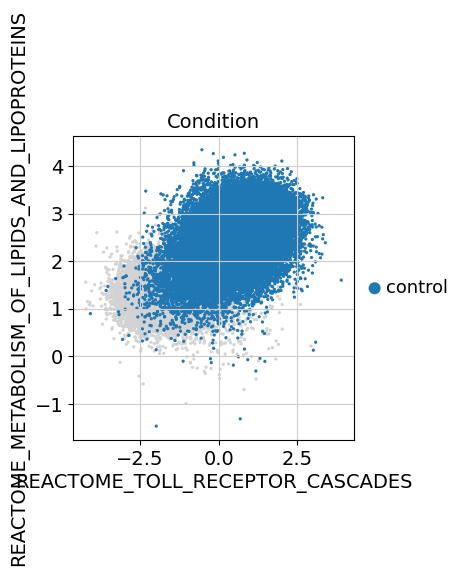

In [608]:
sc.pl.scatter(macro, x='REACTOME_TOLL_RECEPTOR_CASCADES', y='REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', 
              color='condition', size=22, title='Condition', groups="control")

In [522]:
adata.varm["I"].shape

(5000, 545)

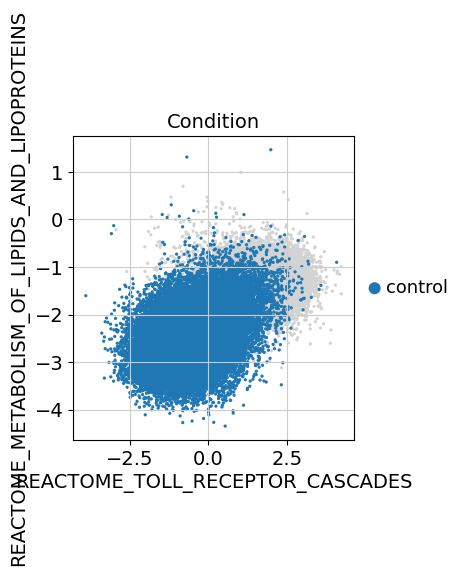

In [582]:
sc.pl.scatter(macro, x='REACTOME_TOLL_RECEPTOR_CASCADES', y='REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS', 
              color='condition', size=22, title='Condition', groups="control")

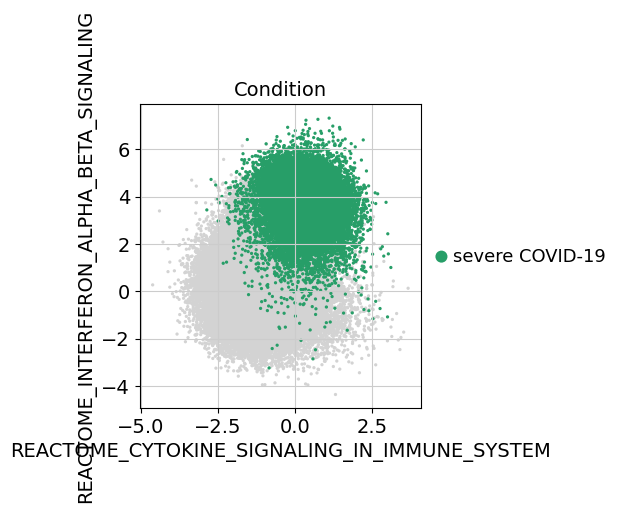

In [510]:
sc.pl.scatter(macro, x='REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM', y='REACTOME_INTERFERON_ALPHA_BETA_SIGNALING', 
              color='condition', size=22, title='Condition', groups="severe COVID-19")

In [542]:
adata_raw = sc.read('./covid_raw_sergey.h5ad')

In [565]:
macro = adata[adata.obs.celltype == "Macrophages"]

In [568]:
macro.raw.X

<32567x18474 sparse matrix of type '<class 'numpy.float32'>'
	with 46053228 stored elements in Compressed Sparse Row format>

In [549]:
sc.pp.log1p(adata_raw)

In [569]:
sc.pl.scatter(macro, x='REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM',
              y='REACTOME_INTERFERON_ALPHA_BETA_SIGNALING', 
              color='CCL2', size=22, title='Condition',use_raw=True, )

ValueError: `x`, `y`, and potential `color` inputs must all come from either `.obs` or `.var`

In [555]:
adata.raw = adata_raw

In [534]:
adata.varm["I"][:,503] == 1

array([False, False, False, False, False, False, False, ..., False, False,
       False, False,  True, False, False])

In [530]:
for i, j in enumerate(adata.uns["terms"]):
    if j == "REACTOME_TOLL_RECEPTOR_CASCADES":
        print(i)

503


In [ ]:
REACTOME_TOLL_RECEPTOR_CASCADES